# Tarea N2 - Problema 1

Un problema que podemos encontrar transversalmente a todos los modelos es el problema de _overfitting_. Este problema consiste en un modelo que aprende demasiado bien los datos de ejemplo o entrenamiento, al punto que el momento de ver ejemplos desconocidos o de validación, baja su desempeño respecto a un modelo "menos entrenado". En algunos casos podriamos decir que el modelo "aprende de memoria" los ejemplos, en vez de intentar obtener información generalizable a partir de su entrenamiento. Para el caso de la regresión, una de las aproximaciones más comunes para tratar de mitigar este efecto es el de la regularización. Agregando una penalización a la norma de los parámetros de la regresión podemos restringir la eficiencia del modelo al momento de aprender los datos de entrenamientos, incluso forzando dependiendo de la intensidad de la regularización que algunos parámetros se vuelvan cero.

<img src="https://openweathermap.org/themes/openweathermap/assets/img/new-history-forecast-bulk.png"  style="height:9cm;"  />

En esta pregunta utilizaremos nuevamente la base de datos de climática disponible en https://www.kaggle.com/budincsevity/szeged-weather para predecir la humedad dadas distintas características ambientales y temporales. Utilizaremos estos datos para enfocarnos en la regularización para regresión. Exploraremos como varian los distintos errores de predicción y analizar cómo cambian los valores de los parámetros ajustados por el modelo para distintos valores del coeficiente de regularización, para tratar de entender qué ocurre con las distintas regularizaciones y sus diferencias.

### Ubicación de carpeta en Colab

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd 'My Drive'/'Problema 2'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/My Drive/Problema 2


### Paquetes a utilizar

In [3]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

### 2.a Carga y preprocesamiento

In [4]:
data = pd.read_csv("weatherHistory.csv")
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


**i)** Comente brevemente el contenido de cada una de las columnas del data set

Este dataset consiste en el registro por hora de distintas características metereológica de la ciudad de Szeged, Hungría, entre 2006 y 2016. Cada una de estas características o variables se describen en la siguiente tabla:

|Característica |                      Descripción                         |
|:-------------:|:--------------------------------------------------------:|
|Formatted Date |           Tiempo de registro (AAAA-MM-DD  HH:MM:SS:MMM)  |
|	Summary     | **Resumen**: Parcialmente Nublado / Mayormente Nublado /Nublado /Brumoso / Muy nublado con viento  / Despejado /   Húmedo y Mayormente Nublado /Ventoso / Ventoso y Seco / Ventoso y brumoso / Ventoso y Nublado / Ventoso y Parcialmente nublado / Seco /   Lluvia / Entre Otros|
|Temperature |           Temperatura [°C] |
|Apparent Temperature |          Temperatura Aparente [°C] |
|Humidity |           Humedad: Indicador de la cantidad  de vapor de agua que hay en el aire  |
| Wind Bearing|         Dirección del viento [Grados] |
| Visibility |          Visibilidad [km]  |
| Loud Cover|           |
| Pressure  |          Presión [milibares]|
|Daily Summary| Resumen Diario |



**ii)** Cargue los datos, inicialmente transformaremos la primera columna con el fin de obtener una representación bi-dimensional del mes y hora de cada fecha. A continuación se muestra el proceso para obtener una representación bi-dimensional de la hora, repita el proceso para obtener la representación bivariada del mes. Luego, agregue las 4 variables al dataset original en reemplazo de la columna original " Formatted Dates". Grafique ambas variables bi-dimensionales de manera separada y comente.

In [5]:
# Obtener información del dataset
column_names =  data.columns
dates        =  np.asarray(data[column_names[0]].str.split(n=1,pat="+",expand = True)[0])
hours        =  np.asarray(pd.to_datetime(dates).hour)
months       =  np.asarray(pd.to_datetime(dates).month)

# Representación bi-dimensional de la hora 
hour1        =  np.sin(2*pi*((hours/24)-1))
hour2        =  np.cos(2*pi*((hours/24)-1))

# Representación bi-dimensional de los meses
month1       =  np.sin(2*pi*((months/12)-1))
month2       =  np.cos(2*pi*((months/12)-1))

In [6]:
# Incorporar representación bi-dimensional al dataset
data             =  data.drop([column_names[0]],axis=1)
data["Hour_1"]   =  hour1
data["Hour_2"]   =  hour2
data["Month_1"]  =  month1
data["Month_2"]  =  month2

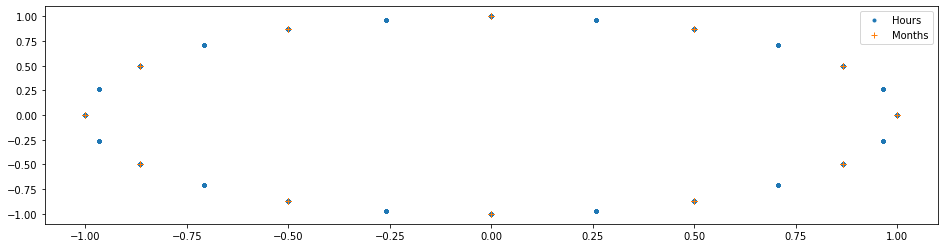

In [33]:
# Gráfico de la representación mencionada
plt.rcParams["figure.figsize"]=[16,4]
plt.plot(hour1,hour2,".",label="Hours")
plt.plot(month1,month2,"+",label="Months")
plt.legend()

**Comentarios:** dado que los datos del tiempo (hora y fecha) están asociados a fenómenos periódicos de la tierra, como lo es el día y la noche, y el pasar de las estaciones del año, realizar esta transformación permitirá analizar de manera más apropiada la incidencia de estos procesos ciclicos sobre la variable climática que se intenta predecir.

**iii)** Borre las columnas categóricas Summary y Daily Summary. Si bien pudiesen usarse con pd.get_dummies, el número de columnas aumentaría en gran medida dificultando el análisis deseado. Tan solo transforme con pd.get_dummies la columna "Precip Type"

In [8]:
data = data.drop(["Daily Summary"],axis=1)
data = data.drop(["Summary"],axis=1)
Dum  = pd.get_dummies(data["Precip Type"])           # Obtener variables dummies
data = data.drop(["Precip Type"],axis=1)
data[Dum.columns] = Dum

In [9]:
data.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Hour_1,Hour_2,Month_1,Month_2,rain,snow
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,2.449294e-16,1.000000,0.866025,-0.5,1,0
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,2.588190e-01,0.965926,0.866025,-0.5,1,0
2,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,5.000000e-01,0.866025,0.866025,-0.5,1,0
3,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,7.071068e-01,0.707107,0.866025,-0.5,1,0
4,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,8.660254e-01,0.500000,0.866025,-0.5,1,0


**iv)** Separe el dataset, utilice 0.7 de los datos como training set, 0.2 como validation set y 0.1 como test set, verifique el tamaño de cada conjunto. Utilice la columna Humidity como target.

In [10]:
# Obtener target y dataset a utilizar
Y = data["Humidity"]
X = data.drop(["Humidity"],axis=1)

# División de conjuntos
x_tr,x_tst,y_tr,y_tst = train_test_split(X,Y,test_size=0.1)
x_tr,x_val,y_tr,y_val = train_test_split(x_tr,y_tr, test_size = 2/9)

print("El tamaño del train set es", x_tr.shape,"corresponde a un",np.round(x_tr.shape[0]/data.shape[0]*100),"%")
print("El tamaño del validation set es", x_val.shape,"corresponde a un",np.round(x_val.shape[0]/data.shape[0]*100),"%")
print("El tamaño del test set es", x_tst.shape,"corresponde a un",np.round(x_tst.shape[0]/data.shape[0]*100),"%")

El tamaño del train set es (67516, 13) corresponde a un 70.0 %
El tamaño del validation set es (19291, 13) corresponde a un 20.0 %
El tamaño del test set es (9646, 13) corresponde a un 10.0 %


**v)** Estandarice el resto de las variables continuas

In [11]:
# Ajuste a los valores del train set
scaler_x = StandardScaler()
scaler_x.fit(x_tr.values)
scaler_y = StandardScaler()
scaler_y.fit(y_tr.values.reshape(-1,1))

# Ajustar las variables del train set
x_tr_st = scaler_x.transform(x_tr.values)
y_tr_st = scaler_y.transform(y_tr.values.reshape(-1,1))

# Ajustar las variables del validation set
x_val_st = scaler_x.transform(x_val.values)
y_val_st = scaler_y.transform(y_val.values.reshape(-1,1))

# Ajustar las variables del test set
x_tst_st = scaler_x.transform(x_tst.values)
y_tst_st = scaler_y.transform(y_tst.values.reshape(-1,1))

**2.b Modelo sin regularización**

Entrene un modelo de regresión lineal no regularizado con los datos preprocesados. Calcule el error cuadrático medio (MSE) del modelo para el conjunto de validación y el de entrenamiento.

In [37]:
# Ajuste de modelo lineal 
reg = LinearRegression()
reg.fit(x_tr_st,y_tr_st)
error_val = mean_squared_error(y_val_st, reg.predict(x_val_st))
error_tr  = mean_squared_error(y_tr_st, reg.predict(x_tr_st))
score_tr  = reg.score(x_tr_st,y_tr_st)
score_val = reg.score(x_val_st,y_val_st)

print('Para el train set se tiene:')
print('Error cuadrático medio:',error_tr)
print('Score:',score_tr)

print("")

print('Para el validation set se tiene:')
print('Error cuadrático medio:',error_val)
print('Score:',score_val)

Para el train set se tiene:
Error cuadrático medio: 0.35702388879552754
Score: 0.6429761112044723

Para el validation set se tiene:
Error cuadrático medio: 0.35643673679568166
Score: 0.6460750311476


**Comentarios:** de acuerdo a los resultados, estos son muy similares para ambos conjuntos.

**2.c Regularización**

Discuta que busca realizar (en términos del ajuste de los parámetros del modelo de regresión lineal) la regularización de Lasso. ¿Por qué se habla de penalización en norma $L^1$? Apóyese de ecuaciones. ¿Qué importancia tiene el parámetro de regularización $\lambda$? ¿Qué diferencia hay entre Lasso y Ridge?

**Respuesta**

Mediante la regularización se busca reducir los coeficientes $\beta$ para ajustar de mejor forma el modelo, es utilizado para evitar overfitting. La regularización Lasso utiliza la norma $L^{1}$, la cual está dado por $|w|=\sum_j |w_j|$.  Así, la penalización se puede escribir como:
$$\text{Lasso} = \lambda \sum_{j=1}^p |\beta_j|$$
$$\text{Ridge} = \lambda \sum_{j=1}^p \beta_j^2$$

Por lo tanto, esta regularización estan sujetas al parámetro $\lambda$, donde a mayor  $\lambda$ mayor importancia toma dicho parámetro. 

Es importante mencionar que la utilización de una regularización u otra depende de la relación entre las variables. Si todas las variables están relacionadas con la respuesta, entonces funcionará mejor Ridge debido a que no anula los coeficientes. En caso contrario, funcionará mejor Lasso.

**2.d Influencia sobre el error**

Grafique como varia el error de entrenamiento y el error de validación a medida se cambia el valor del parámetro $\lambda$. Para esto debe entrenar un modelo para cada uno de los parámetros que considerará en el gráfico y calcular el MSE para ambos sets. Comente sobre lo que ve en el gráfico y si lo encuentra pertinente puede calcular en más detalle alguna zona que le parezca interesante. Es conveniente entrenar primero unos cuantos modelos con valores de $\lambda$ escogidos manualmente para saber mejor en que intervalo resulta pertinente calcular estos valores (para Ridge se necesita valores más altos en este caso para ver la influencia sobre el error)

Note que el parámetros $\lambda$ es sensible a la escala de los datos, por lo cual deberá estudiar valores distintos dependiendo de si estandarizó el target o no.

### Utilizando Lasso

In [41]:
MSE_tr_lasso   =  []
MSE_val_lasso  =  []
space_lasso    =  np.logspace(-3,0,100)
coef_lasso     =  []

for lambd in space_lasso: 
    # Ajuste para un determinado lambda
    reg_lasso = Lasso(alpha=lambd)
    reg_lasso.fit(x_tr_st,y_tr_st)
    
    # Cálculo de predicción y error para tr y val set
    pred_tr  = reg_lasso.predict(x_tr_st)
    pred_val = reg_lasso.predict(x_val_st)
    MSE_tr_lasso.append(mean_squared_error(y_tr_st,pred_tr))
    MSE_val_lasso.append(mean_squared_error(y_val_st,pred_val))   
    coef_lasso.append(reg_lasso.coef_)

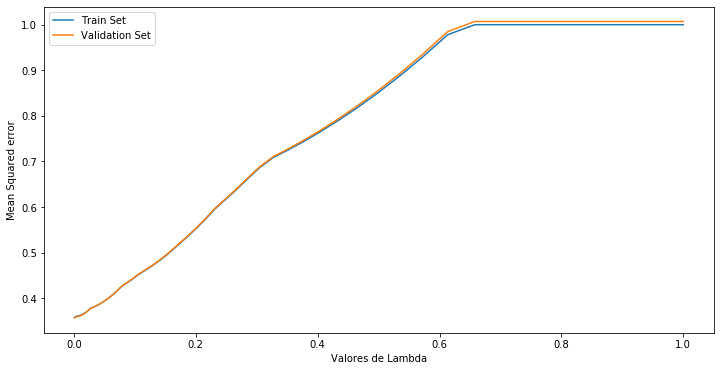

In [94]:
# Gráfico del error 
plt.figure(figsize=(12,6))
ax = plt.gca()
plt.plot(space_lasso,MSE_tr_lasso,label='Train Set')
plt.plot(space_lasso,MSE_val_lasso,label='Validation Set')
plt.xlabel('Valores de Lambda')
plt.ylabel('Mean Squared error')
plt.legend()

**Comentarios:**

Se puede ver que los errores de ambos conjuntos son practicamente iguales, pero se puede apreciar que el error de entrenamiento es levemente menor al error de validación. Además, se ve que para valores entre 0.1 y 1, el error aumenta considerablemente producto de una pequeña variación de lambda, se atribuye esto a que la regularización mediante Lasso llevó unos coeficientes a 0.

### Utilizando Ridge

In [51]:
MSE_tr_ridge   =  []
MSE_val_ridge  =  []
space_ridge    =  np.logspace(3,8,100)
coef_ridge     =  []

for lambd in space_ridge: 
    # Ajuste de Modelo
    reg_ridge = Ridge(alpha=lambd)
    reg_ridge.fit(x_tr_st,y_tr_st)
    
    # Cálculo de la predicción y del error 
    pred_tr  = reg_ridge.predict(x_tr_st)
    pred_val = reg_ridge.predict(x_val_st)
    MSE_tr_ridge.append(mean_squared_error(y_tr_st,pred_tr))
    MSE_val_ridge.append(mean_squared_error(y_val_st,pred_val))   
    coef_ridge.append(reg_ridge.coef_)

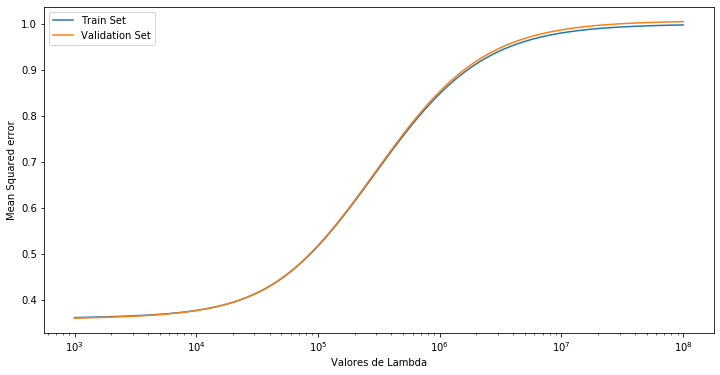

In [96]:
# Gráfico del error 
plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_xscale('log')
plt.plot(space_ridge,MSE_tr_ridge,label='Train Set')
plt.plot(space_ridge,MSE_val_ridge,label='Validation Set')
plt.xlabel('Valores de Lambda')
plt.ylabel('Mean Squared error')
plt.legend()

**Comentarios:** 

Al igual que en el caso anterior, el error de train es menor que el de validation, pero levemente. El rango donde varía el error es ampliamente mayor respecto a Lasso, esto se puede explicar por la norma que se utiliza. Por la misma razón, la curva del error es más suave.

**2.e Influencia sobre los coeficientes**

Grafique ahora como se comporta el valor de los coeficientes del modelo lineal en el modelo entrenado a medida que crece $\lambda$, tanto para Lasso como para Ridge. Para esto entrene un modelo para cada valor de $\lambda$ y guarde sus coeficientes, como propone el principio de código a continuación. Debe explorar valores de $\lambda$ donde todos los coeficientes sean no nulos hasta valores donde todos los coeficientes se anulan.

¿Qué diferencia ve entre Ridge y Lasso?¿Coincide este comportamiento con lo que esperaría teóricamente de cada uno de los modelos?

¿Podemos utilizar estos gráficos para discutir sobre la cantidad de información que entrega cada uno de los atributos para predecir el target?¿Cuál de ambos (Ridge o Lasso) le parece mejor para este tipo de discusión? Compare lo que muestran estos gráficos con la correlación entre las variables usadas para la predicción y target. Discuta.

Text(0.5, 1.0, 'Coeficientes utilizando Lasso')

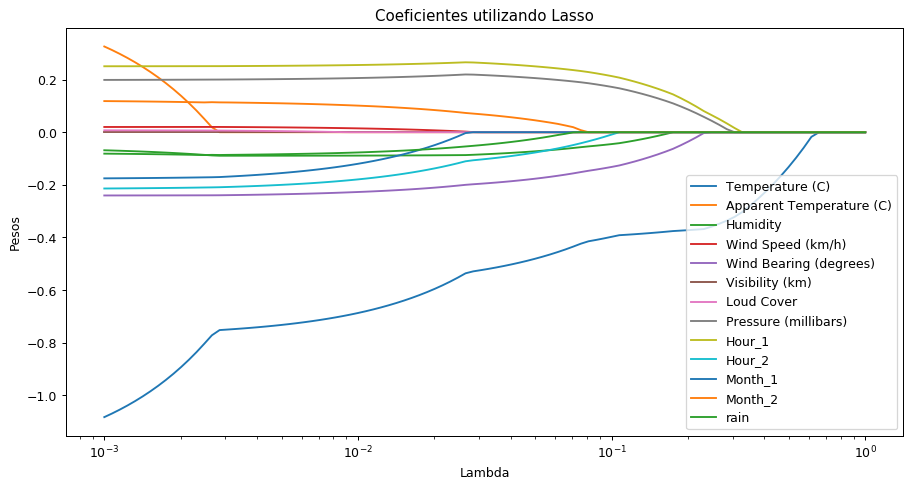

In [44]:
# Gráfico de los coeficientes
columns_val = data.columns
plt.figure(figsize=(12,6),dpi=90)
ax = plt.gca()
ax.set_xscale('log')

for y_arr, leg in zip(np.squeeze(coef_lasso).T, columns_val):
    ax.plot(space_lasso,y_arr,label=leg)
    plt.legend(loc=0)
plt.xlabel('Lambda')
plt.ylabel('Pesos')
plt.title('Coeficientes utilizando Lasso')

Text(0.5, 1.0, 'Coeficientes utilizando Ridge')

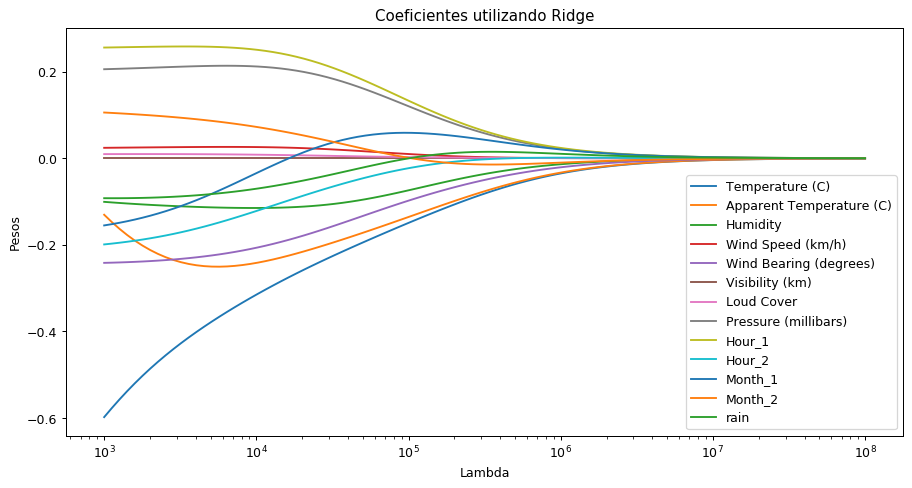

In [57]:
# Gráfico de los coeficientes
columns_val = data.columns
plt.figure(figsize=(12,6),dpi=90)
ax = plt.gca()
ax.set_xscale('log')

for y_arr, leg in zip(np.squeeze(coef_ridge).T, columns_val):
    plt.plot(space_ridge,y_arr,label=leg)
    plt.legend(loc=0)
plt.xlabel('Lambda')
plt.ylabel('Pesos')
plt.title('Coeficientes utilizando Ridge')

### Utilizando Mutual information

In [75]:
from sklearn.feature_selection import mutual_info_regression
MI = list(zip(mutual_info_regression(x_tr_st,y_tr_st.ravel()),data.columns))

Text(0, 0.5, 'MI')

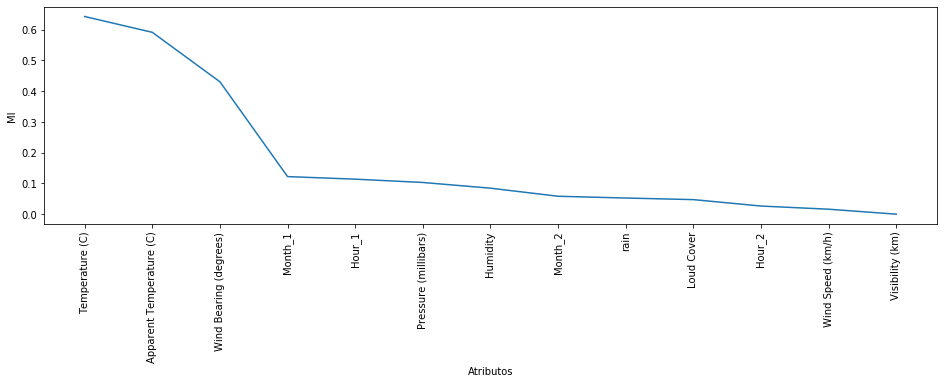

In [78]:
# Gráfico de mutual information
MI = pd.DataFrame(MI, columns=['MI','Atributo']).sort_values('MI',ascending=False)
plt.rcParams['figure.figsize']=[16,4]  
plt.plot(MI['Atributo'],MI['MI'])
plt.xticks(rotation=90)
plt.xlabel('Atributos')
plt.ylabel('MI')

**Comentarios:**

* La primera gran diferencia, que las curvas de Ridge son más suaves que las curvas de Lasso.
* Por otro lado, los coeficientes en Lasso van uno a uno cayendo a 0, mientras que para Ridge practicamente todos los coeficientes llegan a 0 para un mismo valor de lambda.
* Este comportamiento tiene relación con lo esperado teóricamente.
* Se puede ver que los primerps 3 atributos son los que mayor información aportan, segun mutual information. Esto es consistente con los gráfico de los coeficientes de Lasso y Ridge.

**2.f K-fold sobre $\lambda$**

Realice 5-fold o 10-fold sobre el parámetro de regularización $\lambda$, ya sea para Lasso o Ridge. Explore a lo menos 20 valores distintos de $\lambda$ en un intervalo relevante luego de lo aprendido en los preguntas anteriores. Utilice MSE como el error a minimizar.

Compare el error de entrenamiento y de validación para este modelo respecto al modelo lineal sin regularización entrenado inicialmente. ¿En su opinión se alcanza a apreciar el fenómeno de overfitting para este conjunto de datos y el modelo logístico?

### Utilizando Ridge


In [79]:
# Unir train y validation set
x_tr1,x_tst1,y_tr1,y_tst1 = train_test_split(X,Y,test_size=0.1)

# Estandarización de los datos
scaler_x = StandardScaler()
scaler_x.fit(x_tr1.values)
scaler_y = StandardScaler()
scaler_y.fit(y_tr1.values.reshape(-1,1))

# Ajustar las variables del train set
x_tr_st1 = scaler_x.transform(x_tr1.values)
y_tr_st1 = scaler_y.transform(y_tr1.values.reshape(-1,1))

In [87]:
lambda_cand        =   np.logspace(3,8,100)
error_lambda_tr    =   []
error_lambda_val   =   []
fold               =   KFold(5)
error              =   float('inf')

for lambd in lambda_cand:
    error_val_fold   =  []
    error_tr_fold    =  []
    for train_index, val_index in fold.split(x_tr_st1):
        x_tr_fold   =  x_tr_st1[train_index]
        y_tr_fold   =  y_tr_st1[train_index]
        x_val_fold  =  x_tr_st1[val_index]
        y_val_fold  =  y_tr_st1[val_index] 

        # Ajustar el modelo
        reg_ridge = Ridge(alpha=lambd)
        reg_ridge.fit(x_tr_fold,y_tr_fold)

        # Cálculo del error 
        pred_tr  = reg_ridge.predict(x_tr_fold)
        mse_tr   = mean_squared_error(y_tr_fold,pred_tr)
        pred_val = reg_ridge.predict(x_val_fold)
        mse_val  = mean_squared_error(y_val_fold,pred_val)
        
        error_tr_fold.append(mse_tr)
        error_val_fold.append(mse_val)
    error_lambda_tr.append(np.mean(error_tr_fold))
    error_lambda_val.append(np.mean(error_val_fold))
    if np.mean(error_val_fold) < error:
        error = np.mean(error_val_fold)
        lambda_final = lambd

El lambda óptimo es 1000.0 con un error igual a 0.36099900551142117


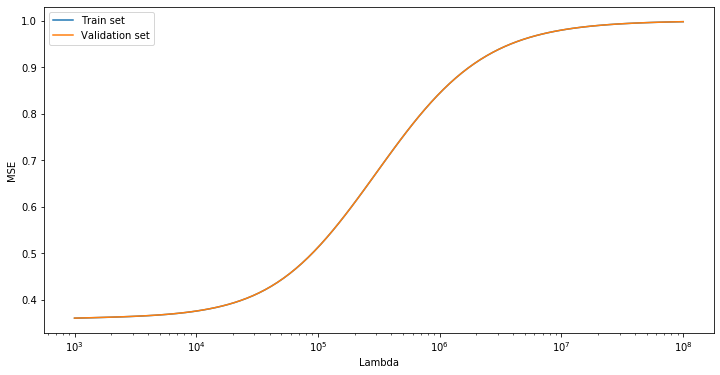

In [88]:
# Gráfica
plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_xscale('log')
plt.plot(lambda_cand,error_lambda_tr, label= "Train set")
plt.plot(lambda_cand,error_lambda_val, label="Validation set")
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("MSE")
print('El lambda óptimo es',lambda_final, "con un error igual a",error)

In [92]:
# Utilizando el valor de lambda = 1000
reg_final  =  Ridge(alpha=1000)
reg_final.fit(x_tr_st,y_tr_st)
score_tr   =  reg_final.score(x_tr_st,y_tr_st)
score_tst  =  reg_final.score(x_tst_st,y_tst_st)

print("Score para train set:",score_tr)
print("Score para test set:",score_tst)

Score para train set: 0.6382415199741903
Score para test set: 0.6343698434020175


**Comentarios:** 

No se produce overfitting debido a que ninguno de los score son excesivamente alto o diferentes.

**2.g Grid Search para SVM**

Para terminar, comparemos el desempeño de los métodos lineales con un método no lineal, las SVM. Para esto buscaremos ajustar los hiperparámetros más relevantes del modelo, en este caso el parámetros C y epsilon, la penalización y el margen de holgura. Comente sobre la significacia de estos parámetros y su influencia sobre la máquina. Luego, realice una búsqueda en un mallado de estos parámetros, evaluando el score (coeficiente de determinación) o MSE o ambos.

Nota: entrenar una SVM toma mucho más tiempo que las regresiones lineales, por lo cual es recomendable probar su código en un número reducido de puntos y luego entrenar todos los modelos asegurandose de guardar bien los resultados. Si su máqquina es muy lenta es incluso recomendable que esta parte la realice en Colab de Google si desea explorar un número relevante de puntos. El mallado propuesto en el código es de referencia y puede elegirlo o construirlo como usted estime conveniente. 

De todos los modelos entrenados, ¿Cuál es el mejor?¿Cómo se compara el desempeño de este modelo con el mejor modelo lineal encontrado por usted? Adjunte gráficos que le parezcan relevantes.

**Importancia de los parámetros**

**C:**

Este es una especie de parámetro regularizador, corresponde al valor que multiplica a la variable de holgura. Cuando se tiene un valor muy alto de C, el valor de $\psi$  tiende a 0, lo cual corresponde al caso lineal, sin relajar el supuesto de linealmente separable. En caso contrario, se da flexibilidad a dicho supuesto, si se considera un valor de C muy bajo, por ende,  $\psi$ muy grande, esto flexibilizaría el supuesto y aceptaría todos los ejemplos erroneos.

**Epsilon:**

Este parámetro se utiliza para relajar la condición de linealmente separable del modelo y permite que ejemplos erroneos sean considerados. El error se contabiliza como 0 en caso que el margen sea menor a $\epsilon$, mientras que se cálcula como $|y-f(x)|-\epsilon$ en caso contrario.

In [20]:
C             =  np.linspace(1,20,4)
epsilon       =  np.linspace(0.05,1,4)
res_score     =  pd.DataFrame(columns=C,index=epsilon)
score         =  0
res_mse       =  pd.DataFrame(columns=C,index=epsilon)
mse           =  float('inf')
#fold          =  KFold(5)

for c_cand in C:                 # Recorre los valores de C candidatos
    for e_cand in epsilon:         # Recorre los valores de epsilon candidatos
        print("Valor de C",c_cand,"y valor de Epsilon", e_cand)
        # Ajustar modelo
        svm = SVR(C=c_cand, epsilon=e_cand)
        svm.fit(x_tr_st,y_tr_st.ravel())
            
        # Guarda resultados
        mse_ce = mean_squared_error(y_val_st,svm.predict(x_val_st))
        score_ce = svm.score(x_val_st,y_val_st)
        res_mse.loc[e_cand,c_cand]   = mse_ce
        res_score.loc[e_cand,c_cand] = score_ce

        # C y epsilon candidatos
        if mse_ce <= mse:
            mse          =  mse_ce
            c_mse        =  c_cand
            epsilon_mse  =  e_cand
        if score_ce >= score:
            score          =  score_ce
            c_score        =  c_cand
            epsilon_score  =  e_cand

Valor de C 1.0 y valor de Epsilon 0.05
Valor de C 1.0 y valor de Epsilon 0.36666666666666664
Valor de C 1.0 y valor de Epsilon 0.6833333333333333
Valor de C 1.0 y valor de Epsilon 1.0
Valor de C 7.333333333333333 y valor de Epsilon 0.05
Valor de C 7.333333333333333 y valor de Epsilon 0.36666666666666664
Valor de C 7.333333333333333 y valor de Epsilon 0.6833333333333333
Valor de C 7.333333333333333 y valor de Epsilon 1.0
Valor de C 13.666666666666666 y valor de Epsilon 0.05
Valor de C 13.666666666666666 y valor de Epsilon 0.36666666666666664
Valor de C 13.666666666666666 y valor de Epsilon 0.6833333333333333
Valor de C 13.666666666666666 y valor de Epsilon 1.0
Valor de C 20.0 y valor de Epsilon 0.05
Valor de C 20.0 y valor de Epsilon 0.36666666666666664
Valor de C 20.0 y valor de Epsilon 0.6833333333333333
Valor de C 20.0 y valor de Epsilon 1.0


In [31]:
res_mse = pd.DataFrame(np.array([(0.204816, 0.197975, 0.196495, 0.195867),(0.207167, 0.199466, 0.198099, 0.197473),(0.223742, 0.215057, 0.213285, 0.212282),(0.278366, 0.251897, 0.247835, 0.247423)]),columns=np.linspace(1,20,4),index=np.linspace(0.05,1,4))

In [24]:
res_score = pd.DataFrame(np.array([(0.79358,	0.800475,	0.801966,	0.802599),(0.791211,	0.798972,	0.80035,	0.80098),(0.774506,	0.783259,	0.785045,	0.786055),(0.719454,	0.746131,	0.750224,	0.75064)]),columns=np.linspace(1,20,4),index=np.linspace(0.05,1,4))

Text(0.5, 1.0, 'MSE vs C para diferentes epsilon')

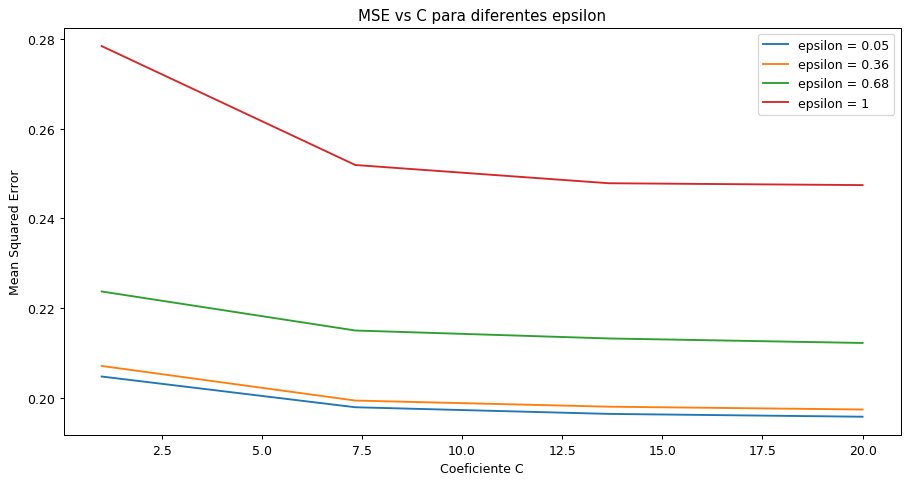

In [32]:
# Gráfico de MSE vs C para diferentes epsilon
plt.figure(figsize=(12,6),dpi=90)
plt.plot(res_mse.columns,res_mse.iloc[0,:],label="epsilon = 0.05")
plt.plot(res_mse.columns,res_mse.iloc[1,:],label="epsilon = 0.36")
plt.plot(res_mse.columns,res_mse.iloc[2,:],label="epsilon = 0.68")
plt.plot(res_mse.columns,res_mse.iloc[3,:],label="epsilon = 1")
plt.legend(loc=0)
plt.ylabel('Mean Squared Error')
plt.xlabel('Coeficiente C')
plt.title('MSE vs C para diferentes epsilon')

Text(0.5, 1.0, 'MSE vs C para diferentes epsilon')

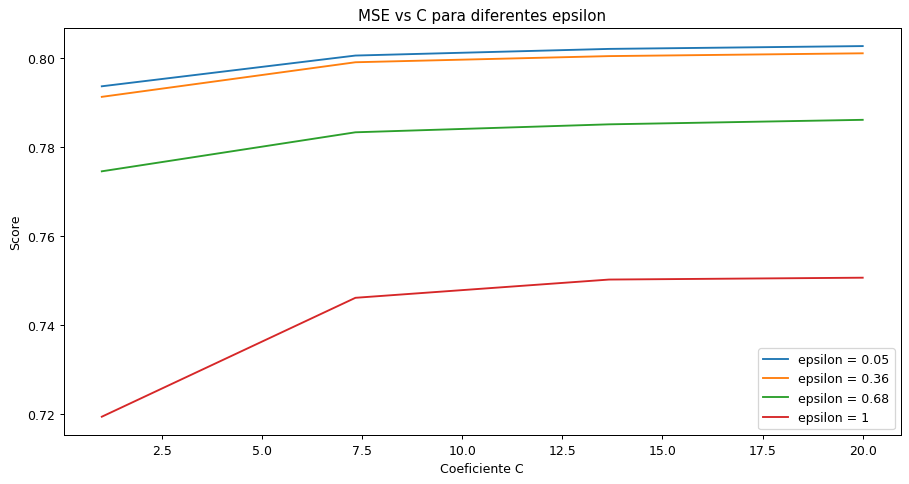

In [29]:
# Gráfico de MSE vs C para diferentes epsilon
plt.figure(figsize=(12,6),dpi=90)
plt.plot(res_score.columns,res_score.iloc[0,:],label="epsilon = 0.05")
plt.plot(res_score.columns,res_score.iloc[1,:],label="epsilon = 0.36")
plt.plot(res_score.columns,res_score.iloc[2,:],label="epsilon = 0.68")
plt.plot(res_score.columns,res_score.iloc[3,:],label="epsilon = 1")
plt.legend(loc=0)
plt.ylabel('Score')
plt.xlabel('Coeficiente C')
plt.title('MSE vs C para diferentes epsilon')

**Comentarios:** 

En los gráficos se puede ver que el mejor caso, respecto al menor error cuadrático medio y al score, corresponde a un valor alto de C y un valor bajo de $\epsilon$. Esto implica que no es necesario flexibilizar tanto el supuesto de linealmente separable.

Debido al alto costo de iteración, no se pudo explorar para valores altos de C y de $\epsilon$ por lo tanto no se puede descartar que aumente el error y disminuye el score.